# DM-36076: Make HiTS completeness plots for PST status talk, Sept. 2022

* based on  DM-34711 HSC with fakes processing
* no APDB available at present due to USDF migration

* Repository is `/repo/main` and collection is `u/mrawls/DM-34711/hsc9813-fakes`

* test on CI for now: `/sdf/home/e/ebellm/u/workspace/cosmos/repo` and collection `ap_verify-output`

* Pipeline is in 
* BPS configuration file is in 
* Logs are in 
* APDB is in Postgres at  in schema `mrawls_DM34710_take2`.

In [1]:
%matplotlib inline
#%matplotlib widget # interactive but doesn't persist


import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

sys.path.append('..')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa
import seaborn as sns

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/dustmaps_cachedata/g41a3ec361e+c9b10be330/config/.dustmapsrc


In [2]:
sns.set_context('talk')

In [3]:
# Only if you change anything in the code imported above
importlib.reload(doa)
importlib.reload(pla)
importlib.reload(plc)
importlib.reload(coa)

<module 'coaddAnalysis' from '/sdf/data/rubin/u/ebellm/workspace/ap_pipe-notebooks/notebooks/../coaddAnalysis.py'>

In [4]:
repo = '/repo/main'
#repo = '/sdf/group/rubin/u/ebellm/workspace/cosmos/repo'
butler = dafButler.Butler(repo)

In [5]:
collection = 'u/mrawls/DM-34710/hits2015-fakes'
#collection = 'ap_verify-output'

#dbSchema = 'mrawls_DM31053'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

In [6]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

In [82]:
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                      dbType='sqlite',
                                                      dbName='association.db',
                                                      isVerify=True,
                                                      schema=None,
                                                      gen='gen3',
                                                      instrument=instrument,
                                                      badFlagList=badFlagList)

In [ ]:
#objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
#                                                      dbType='postgres',
#                                                      dbName='lsstdevapdb1',
#                                                      schema=dbSchema,
#                                                      gen='gen3',
#                                                      instrument=instrument,
#                                                      badFlagList=badFlagList)

In [83]:
srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument=instrument, gen='gen3', butler=butler)
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                               badFlagList=badFlagList,
                                                                               gen='gen3', instrument=instrument,
                                                                               repo=repo)

In [7]:
bandList = ['g', 'r', 'i', 'z', 'y']
colorList = ['C2', 'C1', 'C3', 'C5', 'k']

## Access synthetic source information

The `matchFakesTask` created one `fakes_goodSeeingDiff_matchDiaSrc` per visit and detector. It's a pandas dataframe, so we need to load them all up and create one with everything.

In [8]:
fakesMatchDiaSrc = butler.registry.queryDatasets(collections=collection,datasetType='fakes_goodSeeingDiff_matchDiaSrc')

In [9]:
#fakesMatchDiaSrc = butler.registry.queryDatasets(collections=collection,datasetType='fakes_deepDiff_matchDiaSrc')

In [10]:
len(list(fakesMatchDiaSrc))

5040

In [11]:
%%time
visitDetectorFrames = []

i = 0
maxi = 1000
#maxi = -1

for datasetRef in fakesMatchDiaSrc: 
    try:
        frame = butler.getDirect(datasetRef)
        
        # nondetected sources don't have DIASource records--so propagate metadata to all rows
        # grab a detected row
        w = frame['diaSourceId'] > 0
        if np.sum(w) == 0:
            print(f'No real sources detected in {datasetRef}')
            continue
        ccdVisitId = int(frame.loc[w,'ccdVisitId'].iloc[0])
        filterName = frame.loc[w,'filterName'].iloc[0]
        # propagate to all rows
        frame.loc[:,'ccdVisitId'] = ccdVisitId 
        frame.loc[:,'filterName'] = filterName 
    #except LookupError:
        #print(f'No data for {datasetRef}')
        #continue
    except Exception as e:
        raise(e)
    else:
        visitDetectorFrames.append(frame)
    i+=1
    if i == maxi:
        break

matchedDiaSources = pd.concat(visitDetectorFrames)

matchedDiaSources.loc[:,'ra'] = np.degrees(matchedDiaSources['ra_x'])
matchedDiaSources.loc[:,'decl'] = np.degrees(matchedDiaSources['dec'])

CPU times: user 11.2 s, sys: 2.95 s, total: 14.1 s
Wall time: 55.1 s


In [12]:
matchedDiaSources

,fakeId,dec,ra_x,isVisitSource,isTemplateSource,u_mag,g_mag,r_mag,i_mag,z_mag,...,isDipole,totFlux,totFluxErr,ixx,iyy,ixy,ixxPSF,iyyPSF,ixyPSF,ra
0,12328194368046917380,-0.098725,2.709162,True,False,23.950584,24.715749,23.950584,23.950584,23.950584,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.223537
1,10786914589037533224,-0.098930,2.711430,True,False,21.569786,22.098522,21.569786,21.569786,21.569786,...,False,5256.784466,135.648257,0.136344,0.128592,0.010188,0.147889,-0.001105,-0.001105,155.353507
2,10266316095425061820,-0.098082,2.709603,True,False,21.183443,20.638180,21.183443,21.183443,21.183443,...,False,19996.895435,135.044370,0.145991,0.123429,-0.001963,0.147946,-0.001106,-0.001106,155.248814
3,13728165483901070104,-0.099017,2.709777,True,False,21.609882,22.096219,21.609882,21.609882,21.609882,...,False,5494.136982,204.685183,0.142677,0.130548,-0.002722,0.147845,-0.001105,-0.001105,155.258813
4,9534982547039486306,-0.100171,2.712481,True,False,25.341527,26.307791,25.341527,25.341527,25.341527,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.413685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,9666681264388531435,-0.106794,2.701696,False,True,23.363568,-23.363568,23.363568,23.363568,23.363568,...,False,-79.676424,110.336652,NaN,NaN,NaN,0.138446,0.017514,0.017514,154.795787
108,13107928418719726475,-0.107034,2.700900,False,True,24.116585,-24.116585,24.116585,24.116585,24.116585,...,False,-112.741042,110.524665,NaN,NaN,NaN,0.138417,0.017511,0.017511,154.750149
109,9878930928979279144,-0.105355,2.699246,False,True,23.184871,-23.184871,23.184871,23.184871,23.184871,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.655384
110,13202665334932651569,-0.105892,2.698420,False,True,22.961613,-22.961613,22.961613,22.961613,22.961613,...,False,-259.858533,113.932623,NaN,NaN,NaN,0.138116,0.017472,0.017472,154.608061


In [13]:
matchedDiaSources.columns

Index(['fakeId', 'dec', 'ra_x', 'isVisitSource', 'isTemplateSource', 'u_mag',
       'g_mag', 'r_mag', 'i_mag', 'z_mag', 'y_mag', 'disk_semimajor',
       'bulge_semimajor', 'disk_n', 'bulge_n', 'disk_axis_ratio',
       'bulge_axis_ratio', 'disk_pa', 'bulge_pa', 'sourceType', 'x_x', 'y_x',
       'diaSourceId', 'ccdVisitId', 'filterName', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midPointTai', 'bboxSize', 'flags', 'ra_y', 'decl',
       'x_y', 'y_y', 'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr', 'psFlux',
       'psFluxErr', 'psChi2', 'psNdata', 'trailFlux', 'trailRa', 'trailDecl',
       'trailLength', 'trailAngle', 'dipMeanFlux', 'dipMeanFluxErr',
       'dipFluxDiff', 'dipFluxDiffErr', 'dipLength', 'dipAngle', 'dipChi2',
       'isDipole', 'totFlux', 'totFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF',
       'iyyPSF', 'ixyPSF', 'ra'],
      dtype='object')

In [14]:
np.sum(matchedDiaSources['diaSourceId'] > 0) /len(matchedDiaSources)

0.5711216542834124

In [15]:
wScienceOnly = matchedDiaSources['isVisitSource'] & ~matchedDiaSources['isTemplateSource']
wMatched = matchedDiaSources['diaSourceId'] > 0

In [16]:
np.sum(wMatched & wScienceOnly) /np.sum(wScienceOnly)

0.6033684115848175

In [17]:
# we need a spatial cut here.  spherical would be bettter
minra = matchedDiaSources.loc[wScienceOnly & wMatched,'ra'].min()
maxra = matchedDiaSources.loc[wScienceOnly & wMatched,'ra'].max()
mindecl = matchedDiaSources.loc[wScienceOnly & wMatched,'decl'].min()
maxdecl = matchedDiaSources.loc[wScienceOnly & wMatched,'decl'].max()

#wRADec = (matchedDiaSources.ra < 151.0 ) & (matchedDiaSources.ra > 149.4 ) & \
#           (matchedDiaSources.decl > 1.5 ) & (matchedDiaSources.decl < 2.9 )
wRADec = (matchedDiaSources.ra < maxra ) & (matchedDiaSources.ra > minra ) & \
           (matchedDiaSources.decl > mindecl ) & (matchedDiaSources.decl < maxdecl )

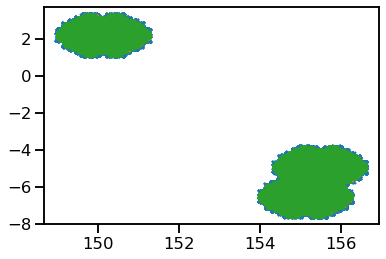

In [18]:
plt.figure()
plt.scatter(matchedDiaSources.loc[wScienceOnly & wMatched,'ra'],matchedDiaSources.loc[wScienceOnly & wMatched,'decl'],marker='x')
plt.scatter(matchedDiaSources.loc[wScienceOnly & ~wMatched,'ra'],matchedDiaSources.loc[wScienceOnly & ~wMatched,'decl'],marker='.')
plt.scatter(matchedDiaSources.loc[wScienceOnly & wRADec,'ra'],matchedDiaSources.loc[wScienceOnly & wRADec,'decl'],marker='+')

In [19]:
bins = np.linspace(20, 26, 70)
n_matched, edges = np.histogram(matchedDiaSources.loc[wMatched& wScienceOnly & wRADec,'g_mag'], bins=bins)
nmatched_err = np.sqrt(n_matched)

n_unmatched, edges = np.histogram(matchedDiaSources.loc[~wMatched & wScienceOnly & wRADec, 'g_mag'], bins=bins)
ntot = n_matched + n_unmatched
#print(n_matched, n_unmatched, ntot)
completeness_all = n_matched/ntot

# Attempt to compute some kind of error
ntot_err = np.sqrt(ntot) # compute on total to keep Poisson errors in gaussian regime
#print(ntot_err)
completeness_err_all = completeness_all * np.sqrt((nmatched_err/n_matched)**2. + (ntot_err/ntot)**2.)

/tmp/ipykernel_10454/112319062.py:13: RuntimeWarning: invalid value encountered in true_divide
  completeness_err_all = completeness_all * np.sqrt((nmatched_err/n_matched)**2. + (ntot_err/ntot)**2.)


Text(0, 0.5, 'Completeness')

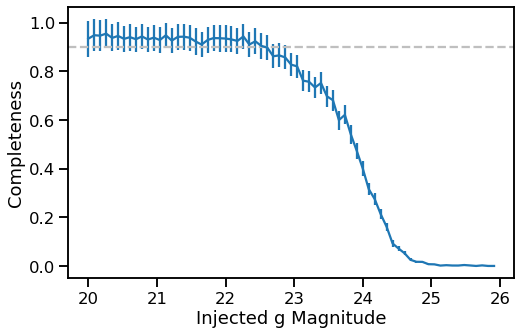

In [20]:
figure = plt.figure(figsize=(8,5))
plt.errorbar(bins[0:-1], completeness_all, completeness_err_all)
#plt.plot(bins[0:-1], completeness, marker='o', ms=5, ls=':')

plt.axhline(.9, ls='--', color='0.75', label='90%')
plt.xlabel('Injected g Magnitude')
plt.ylabel('Completeness')
#plt.ylim(0.7, 1.)

Now break this out by band

In [21]:
bins = np.linspace(20, 26, 70)

completeness_byband = {}
completeness_err_byband = {}

for band in bandList:
    wband = matchedDiaSources['filterName'] == band

    n_matched, edges = np.histogram(matchedDiaSources.loc[wMatched& wScienceOnly & wRADec & wband,f'{band}_mag'], bins=bins)
    nmatched_err = np.sqrt(n_matched)

    n_unmatched, edges = np.histogram(matchedDiaSources.loc[~wMatched & wScienceOnly & wRADec  & wband, f'{band}_mag'], bins=bins)
    ntot = n_matched + n_unmatched
    #print(n_matched, n_unmatched, ntot)
    completeness_byband[band] = n_matched/ntot

    # Attempt to compute some kind of error
    ntot_err = np.sqrt(ntot) # compute on total to keep Poisson errors in gaussian regime
    #print(ntot_err)
    completeness_err_byband[band] = completeness_byband[band] * np.sqrt((nmatched_err/n_matched)**2. + (ntot_err/ntot)**2.)

/tmp/ipykernel_10454/3647316630.py:20: RuntimeWarning: invalid value encountered in true_divide
  completeness_err_byband[band] = completeness_byband[band] * np.sqrt((nmatched_err/n_matched)**2. + (ntot_err/ntot)**2.)
/tmp/ipykernel_10454/3647316630.py:15: RuntimeWarning: invalid value encountered in true_divide
  completeness_byband[band] = n_matched/ntot


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


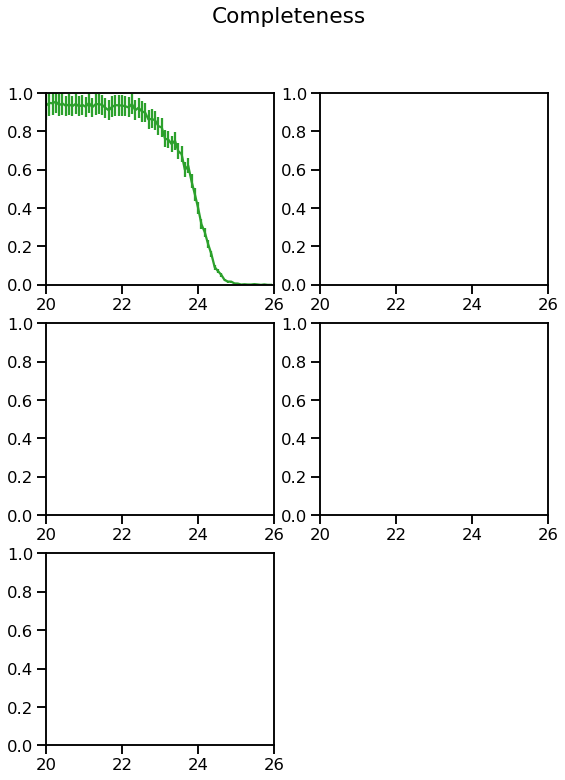

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(9, 12))

axG = axs[0, 0]
axR = axs[0, 1]
axI = axs[1, 0]
axZ = axs[1, 1]
axY = axs[2, 0]
#axHits = axs[2, 1]

ax0 = axs[2, 1]
ax0.axis('off')

axList = [axG, axR, axI, axZ, axY]
colorList = ['C2', 'C1', 'C3', 'C5', 'k']

xlim = (20,26)
ylim = (0, 1)
plt.setp(axs, xlim=xlim, ylim=ylim)

fig.suptitle(f'Completeness')


for ax, band, color in zip(axList, bandList, colorList):
    ax.errorbar(bins[0:-1], completeness_byband[band], completeness_err_byband[band], color=color)

Text(0, 0.5, 'Fractional completeness')

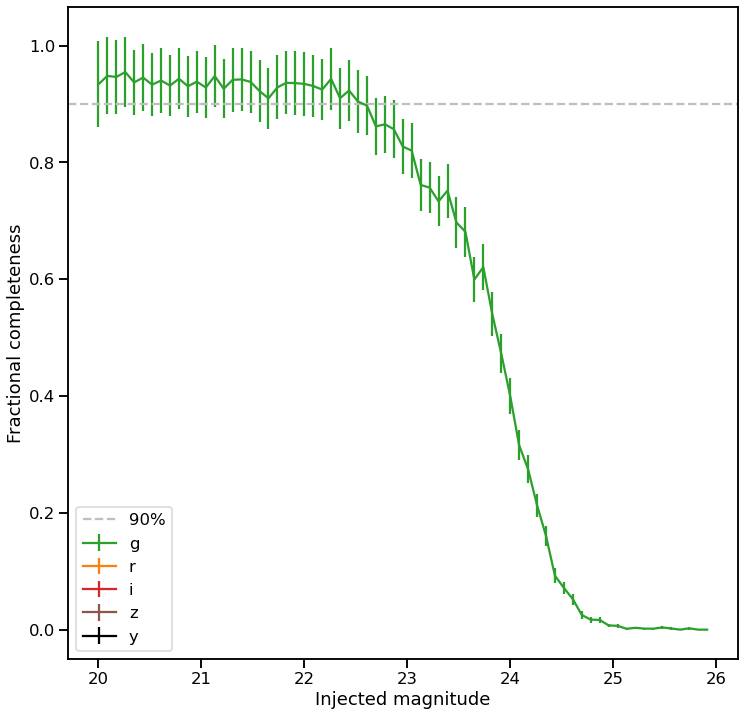

In [23]:
plt.figure(figsize=(12, 12))

colorList = ['C2', 'C1', 'C3', 'C5', 'k']


for  band, color in zip( bandList, colorList):
    plt.errorbar(bins[0:-1], completeness_byband[band], completeness_err_byband[band], color=color,label=band)
plt.axhline(.9, ls='--', color='0.75', label='90%')
plt.legend(loc='lower left')
plt.xlabel('Injected magnitude')
plt.ylabel('Fractional completeness')

### estimate limiting magnitudes by band

To understand the completeness curves above (and to relate to our requirements), we need to understand what the limiting magnitude is for each ccdVisit.  We detect at 5 sigma and our requirements are at 6 sigma.  We can either compute limiting magnitudes empirically, using the observed SNR of our DIASource catalogs, or we can derive them from noise estimates.  Since we're trying to compare the fakes completeness to our expectations, we can't use the fakes themselves to define the limiting magnitudes.

As of this writing it will take a bit of effort to estimate the limiting magnitude from the image properties directly (e.g., through noise  sky objects).  Instead, we will use the catalogued DIASources, and determine the flux (→ magnitude) of sources measured (not detected, since we don't have that information) at SNRs of 5 and 6. 
(Ideally we would only use non-fake DIASources--but that is somewhat of a hassle, so we're actually mixing real and fake DIASources in the analysis below.)

Future improvements would include more rigorous exclusion of fakes, and attempts to derive the limiting magnitude instead from sky sources or the image noise itself.

In [25]:
# make a rough and ready estimate of the flux error
def estimate_fluxlim(flux, fluxerr, snr=5, snr_window_halfwidth=0.1):
    snr_all = np.abs(flux/fluxerr)
    wwindow = ((snr-snr_window_halfwidth) <= snr_all) & (snr_all <=  (snr+snr_window_halfwidth))
    if np.sum(wwindow) < 3:
        return np.nan
    return np.median(np.abs(flux.loc[wwindow]))
    
    
def estimate_maglim(flux, fluxerr, snr=5):
    fluxlim = estimate_fluxlim(flux, fluxerr, snr=snr)
    return (fluxlim * u.nJy).to(u.ABmag).value



In [26]:
estimate_fluxlim(goodSrc['psFlux'],goodSrc['psFluxErr'])

NameError: name 'goodSrc' is not defined

In [87]:
estimate_maglim(goodSrc['psFlux'],goodSrc['psFluxErr'])

26.10899319321281

For each CCDVisit, estimate the 5 and 6 sigma limiting magnitudes:

In [88]:
# a groupby didn't work since I'd need an aggregation function with multiple column inputs
maglims5 = {}
maglims6 = {}

for ccdVisitId, grp in goodSrc.groupby('ccdVisitId'):
    maglims5[ccdVisitId] = estimate_maglim(grp['psFlux'],grp['psFluxErr'],snr=5)
    maglims6[ccdVisitId] = estimate_maglim(grp['psFlux'],grp['psFluxErr'],snr=6)


In [89]:
lim5 = pd.Series(maglims5)
lim5.name = 'maglim5'
lim6 = pd.Series(maglims6)
lim6.name = 'maglim6'

dflim = pd.concat([lim5,lim6],axis=1)

Get the filterName for each CCDVisit:

In [90]:
filter_by_ccd = goodSrc.loc[goodSrc['diaSourceId'] > 0,['ccdVisitId','filterName']].groupby('ccdVisitId').agg(lambda x: np.unique(x)[0])
filter_by_ccd.name = 'filterName'
dflim = dflim.join(filter_by_ccd)

In [91]:
dflim = dflim.reset_index()
dflim.rename(columns={'index':'ccdVisitId'},inplace=True)
dflim

,ccdVisitId,maglim5,maglim6,filterName
0,11830050,26.020757,NaN,g
1,11832051,NaN,25.845396,g


Text(0, 0.5, 'Number of CCD-visits')

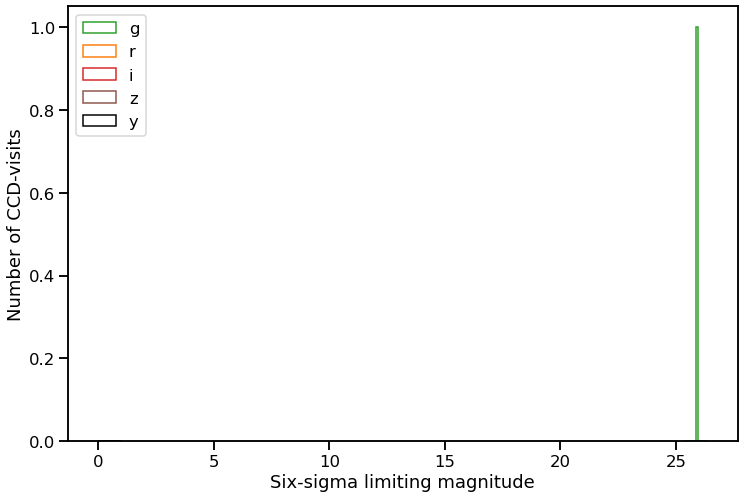

In [98]:
plt.figure(figsize=(12,8))

for band, color in zip( bandList, colorList):
    plt.hist(dflim.loc[dflim['filterName'] == band,'maglim6'],color=color,histtype='step',label=band)
plt.legend()
plt.xlabel('Six-sigma limiting magnitude')
plt.ylabel('Number of CCD-visits')

(0.0, 500.0)

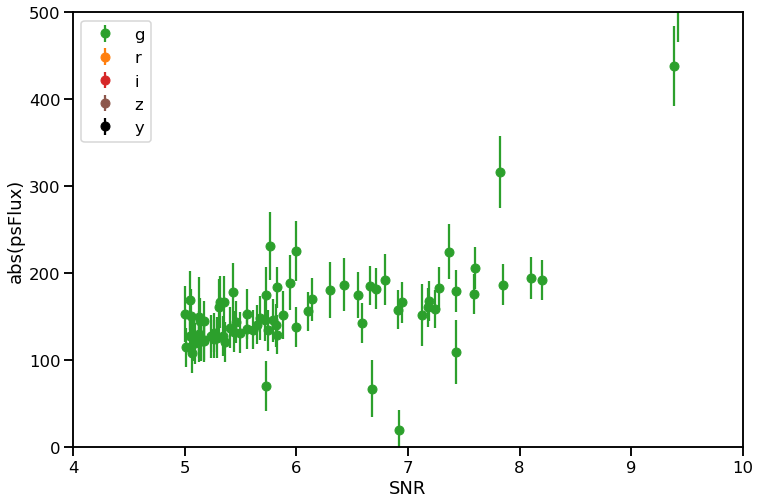

In [110]:
plt.figure(figsize=(12,8))

for band, color in zip( bandList, colorList):
    wband = goodSrc['filterName'] == band
    plt.errorbar(goodSrc.loc[wband,'snr'],
                 np.abs(goodSrc.loc[wband,'psFlux']),
                 goodSrc.loc[wband,'psFluxErr'],
                 color=color,label=band,linestyle='none',fmt='o')
plt.legend()
plt.xlabel('SNR')
plt.ylabel('abs(psFlux)')
plt.xlim(4,10)
plt.ylim(0,500)

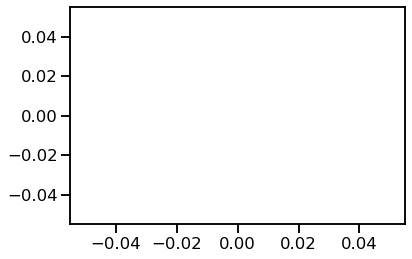

In [93]:
plt.scatter(pd.Series(maglims5).values,pd.Series(maglims6).values)

Determine the 25th and 75th percentile limiting magnitudes by filter:

In [96]:
p25_limmag = dflim.groupby('filterName').agg(lambda x: np.nanpercentile(x,25))
median_limmag = dflim.groupby('filterName').agg(lambda x: np.nanpercentile(x,50))
p75_limmag = dflim.groupby('filterName').agg(lambda x: np.nanpercentile(x,75))

Plot per-filter completeness along with the limiting magnitudes and the required completeness:

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


KeyError: 'r'

> /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/core/indexes/base.py(3623)get_loc()
   3621                 return self._engine.get_loc(casted_key)
   3622             except KeyError as err:
-> 3623                 raise KeyError(key) from err
   3624             except TypeError:
   3625                 # If we have a listlike key, _check_indexing_error will raise



ipdb>  q


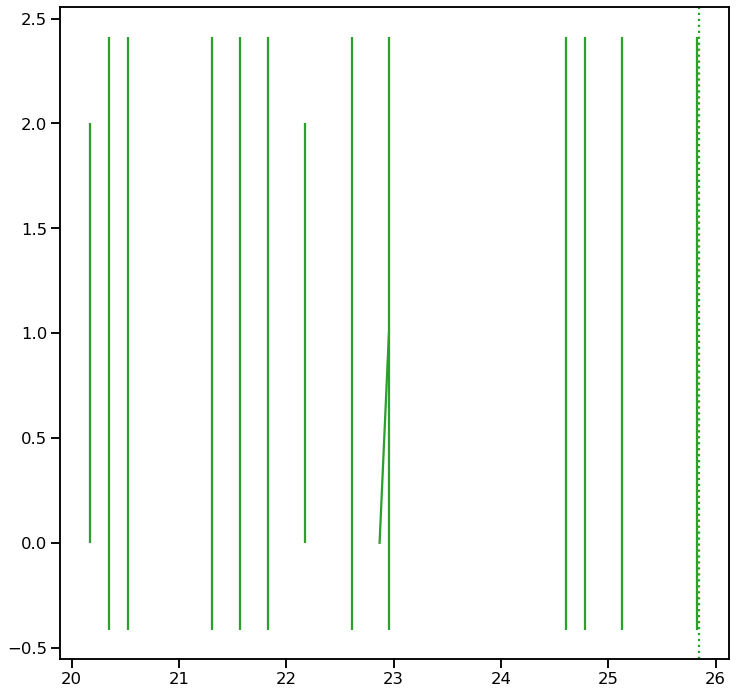

In [97]:
plt.figure(figsize=(12, 12))

colorList = ['C2', 'C1', 'C3', 'C5', 'k']


for  band, color in zip( bandList, colorList):
    plt.errorbar(bins[0:-1], completeness_byband[band], completeness_err_byband[band], color=color,label=band)
    plt.axvline(median_limmag.loc[band,'maglim6'],color=color,ls=':')
    plt.axvspan(p25_limmag.loc[band,'maglim6'],p75_limmag.loc[band,'maglim6'],facecolor=color,alpha=0.2,edgecolor='none')

plt.axhline(.9, ls='--', color='0.75')#, label='90%')
plt.legend(loc='lower left')
plt.xlabel('Injected magnitude')
plt.ylabel('Fractional completeness')

So we are below the required 90% completeness level at 6 sigma in all bands: this need further investigation.  See DM-31388.